In [46]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv('E:\Task scheduling project\priority.csv')
df.head(10)

,Task ID,Priority,Latency,Processing Requirements,Execution Node,Actual Execution Time (ms)
0,1,High,Low,High,Fog,50
1,2,Medium,Medium,Medium,Cloud,200
2,3,Low,High,Low,Fog,30
3,4,High,Low,High,Fog,60
4,5,Low,Medium,Medium,Cloud,150
5,6,Medium,High,Low,Cloud,120
6,7,High,Low,High,Fog,55
7,8,Low,Medium,Medium,Cloud,180
8,9,Medium,High,Low,Fog,40
9,10,High,Low,High,Fog,70


In [47]:
# Check the unique values in the 'Execution Node' column
print("Unique values in 'Execution Node' column:", df['Execution Node'].unique())

Unique values in 'Execution Node' column: ['Fog' 'Cloud']


In [48]:
# Calculate the probabilities for each class
class_counts = df['Execution Node'].value_counts()
total_samples = len(df)
probabilities = class_counts / total_samples

# Ensure probabilities sum to 1
probabilities_sum = probabilities.sum()
if probabilities_sum != 1:
    probabilities /= probabilities_sum

# Calculate entropy
initial_entropy = -sum(prob * math.log2(prob) for prob in probabilities)

print(f"Entropy of the entire dataset: {initial_entropy:.4f}")

Entropy of the entire dataset: 0.9710


In [49]:
# Calculate the entropy of the entire dataset
def calculate_entropy(data):
    class_counts = data['Execution Node'].value_counts()
    probabilities = class_counts / len(data)
    entropy = -sum(prob * math.log2(prob) for prob in probabilities)
    return entropy

initial_entropy = calculate_entropy(df)

# Calculate the information gain for the "Priority" attribute
def calculate_information_gain(data, attribute):
    unique_values = data[attribute].unique()
    weighted_entropy_after_split = 0

    for value in unique_values:
        subset = data[data[attribute] == value]
        subset_weight = len(subset) / len(data)
        weighted_entropy_after_split += subset_weight * calculate_entropy(subset)

    information_gain = initial_entropy - weighted_entropy_after_split
    return information_gain

# Calculate information gain for the each attribute
information_gain_priority = calculate_information_gain(df, 'Priority')
information_gain_latency = calculate_information_gain(df, 'Latency')
information_gain_processing_requirements = calculate_information_gain(df,'Processing Requirements')

print(f"Information Gain for 'Priority': {information_gain_priority:.4f}")
print(f"Information Gain for 'Latency' : {information_gain_latency: .4f}")
print(f"Information Gain for 'Processing Requirements' : {information_gain_processing_requirements: .4f}")

Information Gain for 'Priority': 0.4200
Information Gain for 'Latency' :  0.6955
Information Gain for 'Processing Requirements' :  0.6955


In [50]:
# Choose the attribute with the highest information gain as the splitting criterion
selected_attribute = 'Latency'

# Get unique values of the selected attribute
unique_values = df[selected_attribute].unique()

# Create a dictionary to store subsets
subsets = {}

# Split the dataset into subsets based on the selected attribute
for value in unique_values:
    subsets[value] = df[df[selected_attribute] == value]

# Print the subsets
for value, subset in subsets.items():
    print(f"Subset for {selected_attribute} = {value}:\n{subset}\n")

Subset for Latency = Low:
   Task ID Priority Latency Processing Requirements Execution Node   
0        1     High     Low                    High            Fog  \
3        4     High     Low                    High            Fog   
6        7     High     Low                    High            Fog   
9       10     High     Low                    High            Fog   

   Actual Execution Time (ms)  
0                          50  
3                          60  
6                          55  
9                          70  

Subset for Latency = Medium:
   Task ID Priority Latency Processing Requirements Execution Node   
1        2   Medium  Medium                  Medium          Cloud  \
4        5      Low  Medium                  Medium          Cloud   
7        8      Low  Medium                  Medium          Cloud   

   Actual Execution Time (ms)  
1                         200  
4                         150  
7                         180  

Subset for Latency = Hi

In [51]:
def determine_best_attribute(data, attributes):
    # Calculate the initial entropy of the entire dataset
    initial_entropy = calculate_entropy(data)

    best_attribute = None
    max_information_gain = -1

    # Iterate over candidate attributes
    for attribute in attributes:
        # Calculate information gain for the current attribute
        information_gain = calculate_information_gain(data, attribute)

        # Update best attribute if information gain is higher
        if information_gain > max_information_gain:
            max_information_gain = information_gain
            best_attribute = attribute

    return best_attribute

# Example usage:
attributes_to_consider = ['Priority', 'Latency', 'Processing Requirements']
best_attribute = determine_best_attribute(df, attributes_to_consider)

print(f"The best attribute for splitting is: {best_attribute}")

The best attribute for splitting is: Latency


In [52]:
class DecisionTreeNode:
    def __init__(self, attribute=None, value=None, prediction=None):
        self.attribute = attribute       # Attribute used for splitting
        self.value = value               # Value of the attribute in the parent node
        self.prediction = prediction     # Predicted class for leaf nodes
        self.children = {}               # Dictionary to store child nodes

def build_decision_tree(data, attributes):
    # Stopping criteria: If all instances in the subset belong to the same class
    if len(data['Execution Node'].unique()) == 1:
        # Create a leaf node with the predicted class
        return DecisionTreeNode(prediction=data['Execution Node'].iloc[0])

    # If there are no more attributes to split on, choose the majority class
    if len(attributes) == 0:
        majority_class = data['Execution Node'].mode().iloc[0]
        return DecisionTreeNode(prediction=majority_class)

    # Determine the best attribute for splitting
    best_attribute = determine_best_attribute(data, attributes)

    # Create a decision tree node for the best attribute
    node = DecisionTreeNode(attribute=best_attribute)

    # Recursively split the dataset and build child nodes
    for value in data[best_attribute].unique():
        subset = data[data[best_attribute] == value]
        if subset.empty:
            # If a subset is empty, create a leaf node with the majority class
            majority_class = data['Execution Node'].mode().iloc[0]
            node.children[value] = DecisionTreeNode(prediction=majority_class)
        else:
            # Recursively build child nodes for the subset
            child_node = build_decision_tree(subset, [attr for attr in attributes if attr != best_attribute])
            node.children[value] = child_node

    return node

# Example usage:
attributes_to_consider = ['Priority', 'Latency', 'Processing Requirements']
decision_tree_root = build_decision_tree(df, attributes_to_consider)


In [53]:
def print_decision_tree(tree, feature_names, depth=0):
    if tree.prediction is not None:
        print(f"{'  ' * depth}Predicted class: {tree.prediction}")
    else:
        print(f"{'  ' * depth}Split on attribute '{tree.attribute}'")
        for value, child_node in tree.children.items():
            print(f"{'  ' * (depth + 1)}Value '{value}':")
            print_decision_tree(child_node, feature_names, depth + 2)

# Example usage:
print_decision_tree(decision_tree_root, attributes_to_consider)

Split on attribute 'Latency'
  Value 'Low':
    Predicted class: Fog
  Value 'Medium':
    Predicted class: Cloud
  Value 'High':
    Split on attribute 'Priority'
      Value 'Low':
        Predicted class: Fog
      Value 'Medium':
        Split on attribute 'Processing Requirements'
          Value 'Low':
            Predicted class: Cloud


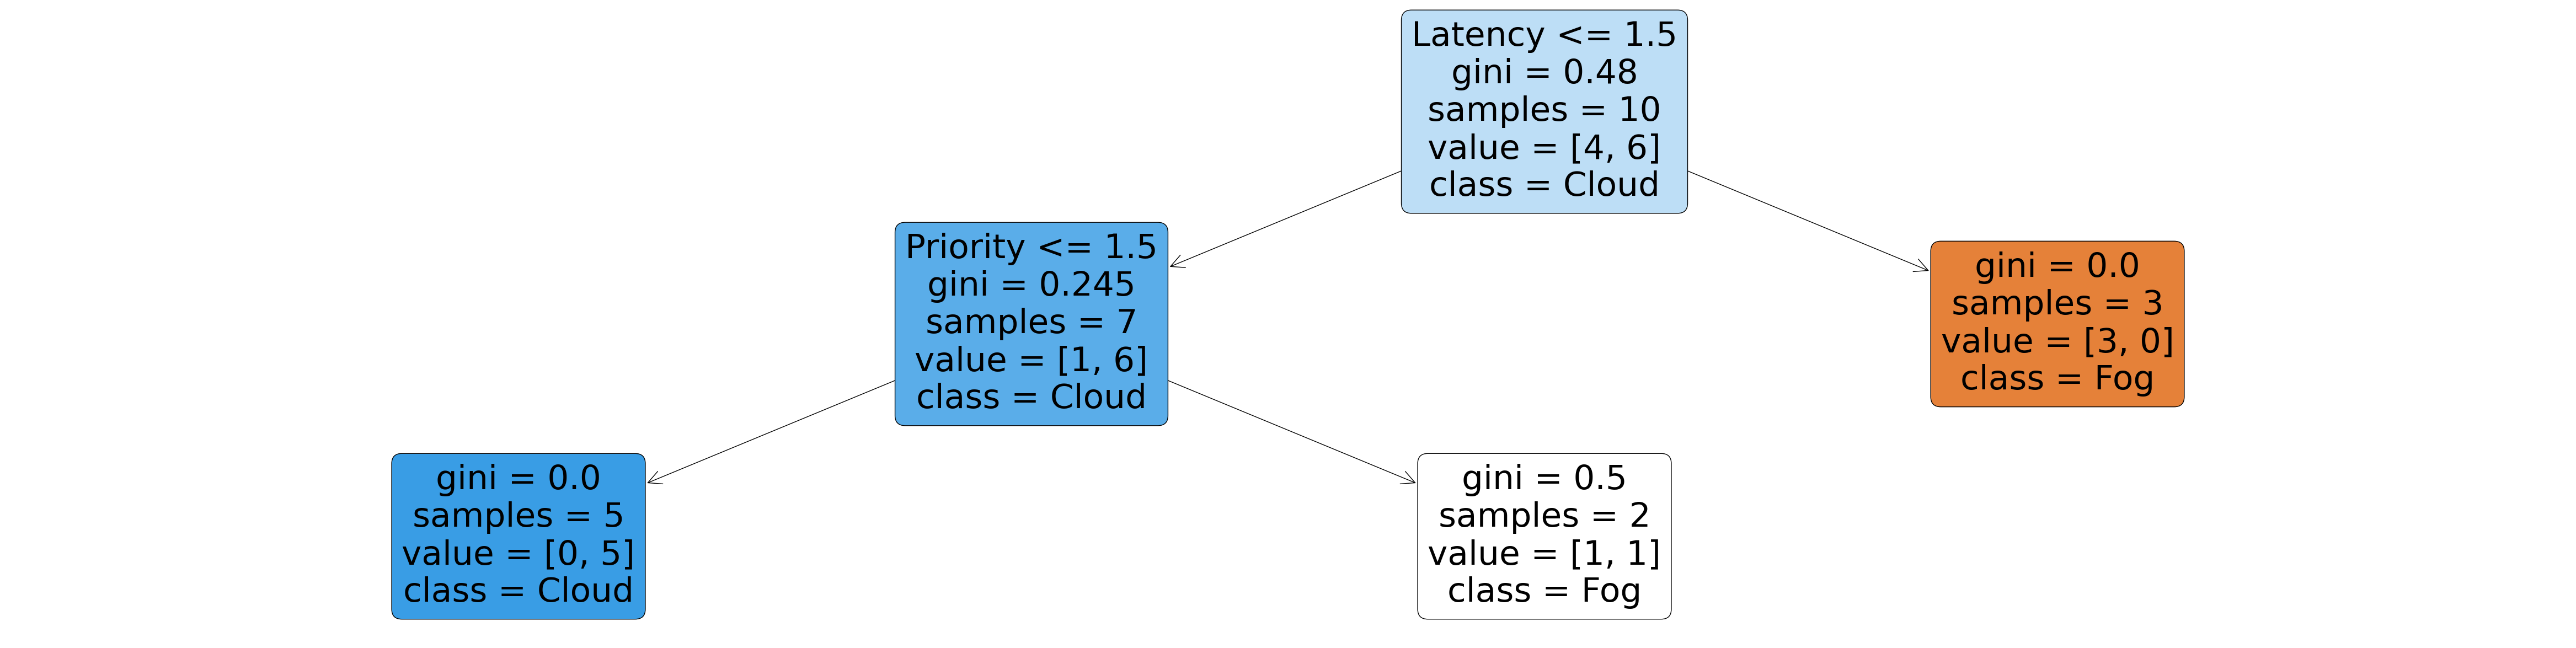

In [54]:
# Label encode categorical variables
le = LabelEncoder()
df['Priority'] = le.fit_transform(df['Priority'])
df['Latency'] = le.fit_transform(df['Latency'])
df['Processing Requirements'] = le.fit_transform(df['Processing Requirements'])

# Build the decision tree using sklearn's DecisionTreeClassifier
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
X = df[['Priority', 'Latency', 'Processing Requirements']]
y = df['Execution Node']
decision_tree_classifier.fit(X, y)
class_names = df['Execution Node'].unique()
# Visualize the decision tree
plt.figure(figsize=(60, 15))
plot_tree(decision_tree_classifier, feature_names=['Priority', 'Latency', 'Processing Requirements'], class_names=class_names, filled=True, rounded=True)
plt.show()

In [55]:
# Generate a synthetic dataset with 1000 samples and categorical features
X_synthetic, y_synthetic = make_classification(
    n_samples=1000,
    n_features=3,  # Number of features
    n_informative=3,  # Number of informative features (all features are informative)
    n_redundant=0,  # Number of redundant features
    n_classes=3,  # Number of classes (to match the number of unique values in categorical features)
    random_state=42
)

# Convert synthetic features to categorical values
label_encoder = LabelEncoder()
X_synthetic_categorical = pd.DataFrame(X_synthetic, columns=['Priority', 'Latency', 'Processing Requirements'])
X_synthetic_categorical['Priority'] = label_encoder.fit_transform(pd.cut(X_synthetic_categorical['Priority'], bins=3, labels=['Low', 'Medium', 'High']))
X_synthetic_categorical['Latency'] = label_encoder.fit_transform(pd.cut(X_synthetic_categorical['Latency'], bins=3, labels=['Low', 'Medium', 'High']))
X_synthetic_categorical['Processing Requirements'] = label_encoder.fit_transform(pd.cut(X_synthetic_categorical['Processing Requirements'], bins=3, labels=['Low', 'Medium', 'High']))

# Create a DataFrame from the synthetic categorical data
synthetic_categorical_df = pd.concat([X_synthetic_categorical, pd.Series(y_synthetic, name='Execution Node')], axis=1)

# Display the first few rows of the synthetic categorical dataset
synthetic_categorical_df.head(1000)

,Priority,Latency,Processing Requirements,Execution Node
0,2,2,2,1
1,2,0,2,0
2,1,2,2,2
3,2,0,0,1
4,2,2,0,2
...,...,...,...,...
995,2,1,2,1
996,0,2,0,1
997,2,0,2,0
998,2,2,2,0


In [56]:
# Split the dataset into features (X) and target variable (y)
X_synthetic_categorical = synthetic_categorical_df[['Priority', 'Latency', 'Processing Requirements']]
y_synthetic_categorical = synthetic_categorical_df['Execution Node']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_synthetic_categorical, y_synthetic_categorical, test_size=0.2, random_state=42)

# Build the decision tree model using sklearn's DecisionTreeClassifier
decision_tree_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
decision_tree_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = decision_tree_classifier.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

print(f"Accuracy on the test set: {accuracy:.2f}")
print("Classification Report:\n", classification_report_str)

Accuracy on the test set: 0.60
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.47      0.57        57
           1       0.66      0.69      0.67        83
           2       0.47      0.60      0.53        60

    accuracy                           0.60       200
   macro avg       0.62      0.59      0.59       200
weighted avg       0.62      0.60      0.60       200

